# Проект: вариант 3

<hr>
<a id="0"></a>

### *Оглавление*

1. [Задание](#1)
2. [Предварительная обработка данных](#2)
3. [A/A тест](#3)
4. [A/B тест](#4)
5. [Заключение](#5)

<a id="1"></a>

## Задание

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

##### Проверьте:

Был ли эксперимент успешен в целом.
Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

#### Данные
Всего есть три группы: 

    тестовая (test), 
    контрольная 1 (control_1) и 
    контрольная 2 (control_2). 

#### Для каждой из них:

##### users_*.csv – информация о пользователях:

    uid – идентификатор пользователя
    age – возраст
    attraction_coeff – коэффициент привлекательности (от 0 до 1000, [лайки/просмотры]*1000) 
    coins – число монеток (внутренняя валюта)
    country – страна  
    visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
    gender – пол
    age_filter_start  – фильтр поиска, мин. значение 
    age_filter_end  – фильтр поиска, макс. значение 
    views_count – число полученных оценок 
    was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
    is_premium –  является ли премиум
    total_revenue – нормированная выручка 
        
##### transactions_*.csv – информация о платежах пользователей:
    uid – идентификатор пользователя
    country – страна
    joined_at – дата и время регистрации
    paid_at – дата и время покупки
    revenue – нормированная выручка
    payment_id – идентификатор платежа
    from_page – откуда пользователь перешел на страницу оплаты
    product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 

##### Датайфреймы:

    ust – информация о пользователях в тестовой группе. 
    usc1 – информация о пользователях в первой контрольной группе. 
    usc2 – информация о пользователях во второй контрольной группе . 
    trt – информация о платежах пользователей в тестовой группе. 
    trc1 – информация о платежах пользователей в первой контрольной группе. 
    trc2 – информация о платежах пользователей во второй контрольной группе 

In [150]:
# Подгружаем библиотеки

import pandas as pd
import numpy as np
import scipy.stats as ss
import mod
from tqdm.auto import tqdm
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [151]:
# Общие настройки для графиков
sns.set(
    rc={
        "figure.figsize": (6, 4),  # размер графика - 8 дюймов в ширину, 6 дюймов в высоту
        "axes.titlesize": 20,  # размер заголовка 
        "axes.labelsize": 14,  # размер подписей осей
        "xtick.labelsize": 13,  # размер подписей чёрточек на x-оси
        "ytick.labelsize": 13,  # размер подписей чёрточек на y-оси
    }
)

sns.set_style("whitegrid")  # тема фона, белая со штриховкой

In [152]:
# Ссылки на файлы

users_test_url = "https://disk.yandex.ru/d/4XXIME4osGrMRA"
users_control_1_url = 'https://disk.yandex.ru/d/yJFydMNNGkEKfg'
users_control_2_url = 'https://disk.yandex.ru/d/br6KkQupzzTGoQ'
transactions_test_url = 'https://disk.yandex.ru/d/gvCWpZ55ODzs2g'
transactions_control_1_url = 'https://disk.yandex.ru/d/VY5W0keMX5TZBQ'
transactions_control_2_url = 'https://disk.yandex.ru/d/th5GL0mGOc-qzg'

In [153]:
# Загружаем данные

ust = pd.read_csv(mod.download_yandex_disk(users_test_url), sep=';')
usc1 = pd.read_csv(mod.download_yandex_disk(users_control_1_url), sep=';')
usc2 = pd.read_csv(mod.download_yandex_disk(users_control_2_url), sep=';')
trt = pd.read_csv(mod.download_yandex_disk(transactions_test_url), sep=';')
trc1 = pd.read_csv(mod.download_yandex_disk(transactions_control_1_url), sep=';')
trc2 = pd.read_csv(mod.download_yandex_disk(transactions_control_2_url), sep=';')

<a id="2"></a>

## Предварительная обработка данных
[в оглавление](#0)  

In [154]:
# Выведем информацию о всех датафреймах

print(ust.info(), usc1.info(), usc2.info(), trt.info(), trc1.info(), trc2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column      

В колонках coins, visit_days, was_premium и is_premium в датафреймах с информацией о пользователях из тестовой и контрольных групп присутствуют пропущенные значения. Так же стоит обратить внимание на пустые строки в датафрейме с информацией о платежах первой контрольной группы. 

Поскольку колонки coins, was_premium и is_premium имею целочисленные значения, преобразуем в соответствующий тип данных.
Преобразуем тип данных колонок с датами в датафреймах с информацией о платежах.  Исправим тип данных колонок в датафрейме с информацией о платежах, соответственно типу данных в подобных колонках в других датафреймах.


In [155]:
# Заполняем пропущенные значения 
ust = ust.fillna(0)
usc1 = usc1.fillna(0)
usc2 = usc2.fillna(0)

# Удаляем пустые строки
trc1 = trc1.dropna()

In [156]:
# Преобразуем типы данных

ust[['coins', 'is_premium', 'was_premium']] = ust[['coins', 'is_premium', 'was_premium']].astype(int)
usc1[['coins', 'is_premium', 'was_premium']] = usc1[['coins', 'is_premium', 'was_premium']].astype(int)
usc2[['coins', 'is_premium', 'was_premium']] = usc2[['coins', 'is_premium', 'was_premium']].astype(int)

trt[['joined_at', 'paid_at']] = trt[['joined_at', 'paid_at']].apply(pd.to_datetime)
trc1[['joined_at', 'paid_at']] = trc1[['joined_at', 'paid_at']].apply(pd.to_datetime)
trc2[['joined_at', 'paid_at']] = trc2[['joined_at', 'paid_at']].apply(pd.to_datetime)

trc1[['uid', 'revenue', 'payment_id']] = trc1[['uid', 'revenue', 'payment_id']].astype(int)

Для чистоты эксперимента наши данные должны быть взяты за одинаковые временные отрезки.
Проверим, что даты начала и окончания регистраций и оплат у всех групп одинаковы.

In [157]:
print(trt.describe(include='datetime'), 
      trc1.describe(include='datetime'), trc2.describe(include='datetime'), sep='\n\n')

                  joined_at              paid_at
count                   273                  273
unique                  146                  258
top     2017-10-18 01:09:00  2017-10-22 22:08:00
freq                     14                    4
first   2017-01-11 03:07:00  2017-01-11 04:37:00
last    2017-10-31 23:40:00  2017-12-11 22:06:00

                  joined_at              paid_at
count                   377                  377
unique                  193                  335
top     2017-10-16 01:38:00  2017-10-16 02:08:00
freq                     27                    5
first   2015-01-19 11:49:00  2016-12-14 16:16:00
last    2017-10-31 22:17:00  2017-12-11 21:57:00

                  joined_at              paid_at
count                   328                  328
unique                  187                  309
top     2017-10-30 15:22:00  2017-10-23 20:17:00
freq                     11                    3
first   2017-01-11 08:36:00  2017-01-11 05:34:00
last    2017-10-31

В первой контрольной группе присуствуют даты регистрации за 2015 год и даты транзакаций за 2016 год. 
Взглянем подробнее.

In [158]:
trc1.query('joined_at < "2017-01-11" or paid_at < "2017-01-11"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26,0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637,0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143,0,refund_WP,other_type


Как видно выше, в логи попали записи о транзакациях за декабрь 2016 года пользователя, зарегистрированного в 2015 году.
Удалим данные строки, чтобы данные в датасетах с логами транзакаций были представлены за эквивалентный промежуток.
Так же удалим строку c uid этого пользователя из таблицы с данными пользователей.

In [159]:
# Удаляем строки

trc1 = trc1.query('uid != 960936960')
usc1 = usc1.query('uid != 960936960')

Проверим датафреймы на наличие дубликатов

In [160]:
print('Количество дубликатов в датафрейме ust:', ust.duplicated().sum(), '\n'
'Количество дубликатов в датафрейме usc1:', usc1.duplicated().sum(), '\n'
'Количество дубликатов в датафрейме usc2:', usc2.duplicated().sum(), '\n'
'Количество дубликатов в датафрейме trt:', trt.duplicated().sum(), '\n'
'Количество дубликатов в датафрейме trc1:', trc1.duplicated().sum(), '\n'
'Количество дубликатов в датафрейме trc2:', trc2.duplicated().sum(), '\n')

Количество дубликатов в датафрейме ust: 0 
Количество дубликатов в датафрейме usc1: 0 
Количество дубликатов в датафрейме usc2: 0 
Количество дубликатов в датафрейме trt: 7 
Количество дубликатов в датафрейме trc1: 21 
Количество дубликатов в датафрейме trc2: 5 



В логах о транзакациях присутсвуют одинаковые строки. 
Однако прежде, чем их удалять проверим сходятся выручки из дасатетов с информацией о пользователях и их транзакаций.

In [161]:
# Сравним общую выручку в датасетах

print(ust.total_revenue.sum() - trt.revenue.sum(),
usc1.total_revenue.sum() - trc1.revenue.sum(),
usc2.total_revenue.sum() - trc2.revenue.sum())

-44083 -30264 0


In [162]:
# Сравним количество уникальных пользователей, совершавших платежи.

print(ust.query('total_revenue>0').uid.nunique() - trt.uid.nunique(),
usc1.query('total_revenue>0').uid.nunique() - trc1.uid.nunique(),
usc2.query('total_revenue>0').uid.nunique() - trc2.uid.nunique())

0 -1 0


Во второй контрольной группе информация, о пользователях совпадает.
В датасетах тестовой и первой контрольной группы в нормированной выручке, вероятно, не хватает информации о некоторых проведенных транзакациях. Посмотрим подробнее. 

In [163]:
# Отличия значений нормированной выручки из датасетов первой контрольной группы

trc1.groupby('uid')\
    .agg({'revenue': 'sum'})\
    .merge(usc1[['uid', 'total_revenue']], how='left', on='uid')\
    .query('revenue != total_revenue')

,uid,revenue,total_revenue
181,892355163,30264,0


In [164]:
# Отличия значений нормированной выручки из датасетов тестовой группы

trt.groupby('uid')\
    .agg({'revenue': 'sum'})\
    .merge(ust[['uid', 'total_revenue']], how='left', on='uid')\
    .query('revenue != total_revenue')

,uid,revenue,total_revenue
129,892275462,58968,14885


Для одного пользователя из тестовой группый и одного пользователя в первой контрольной группе не были учтены в выручке, некоторые транзакции. Изменим значения нормированный выручке в соответсвующих таблицах.

In [165]:
# Корректируем значения

usc1.loc[usc1['uid'] == 892355163, 'total_revenue'] = 30264
ust.loc[ust['uid'] == 892275462, 'total_revenue'] = 58968

Дублирование строк связано с тем, что в логах не учитываются секунды совершения транзакаци, что при эквивалентной сумме транзакации создает идентичные строки.


<a id="3"></a>

## A/A-тест
[в оглавление](#0)  

Прежде чем приступить к анализу результатов проведенного A/B эксперимента, оценим качество системы сплитования трафика, путем анализа однородности выборок двух контрольных групп.

В начале для оценки репрезентативности выборок оценим распределение пользователей в двух контрольных группах по следующим признакам: возраст, пол, страна, время регистрации, количество посещений после регистрации, типа продукта и выручка с пользователя. Поскольку целью эксперимента было проанализировать влияние изменения стоимости премиум-подписки, то затем мы сравним коэффициент конверсии в премиум пользователя (CR), средний доход с привлеченного пользователя (далее ARPU) и средний доход с платящего пользователя (ARPPU). Основным критерием качества работы системы сплитования будет оценка FPR (False Positive Rate) наших ключевых бизнес-метрик.

Объединим датасеты с информацией о пользователях в двух контрольных групп, преварительно создав колонку с номером контрольной группы. 

In [166]:
# Объединяем датафреймы

usc1['group'] = 1
usc2['group'] = 2
usc = pd.concat([usc1, usc2], ignore_index=True)

##### Age

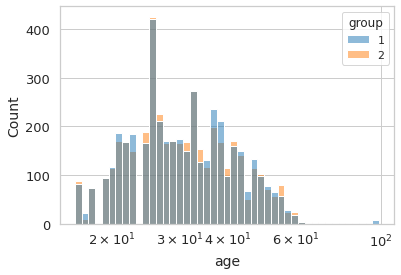

In [167]:
# Cмотрим распределение

sns.histplot(data=usc, x='age', hue='group', palette='tab10', log_scale=(True, False));

In [168]:
# Проверка на нормальность

print(ss.shapiro((usc.age[usc.group == 1])),
ss.shapiro((usc.age[usc.group == 2])), sep='\n')

ShapiroResult(statistic=0.933463454246521, pvalue=2.6340207233913586e-40)
ShapiroResult(statistic=0.9413043856620789, pvalue=3.639819792001761e-38)


In [169]:
# Логарифимрование не позволяет получить нормальные данные

print(ss.shapiro(np.log(usc.age[usc.group == 1])),
ss.shapiro(np.log(usc.age[usc.group == 2])), sep='\n')

ShapiroResult(statistic=0.9886850118637085, pvalue=3.6349111986050465e-18)
ShapiroResult(statistic=0.989700436592102, pvalue=4.414947148453982e-17)


Поскольку распределение ненормально, используя бустрап, проведем t-test. 

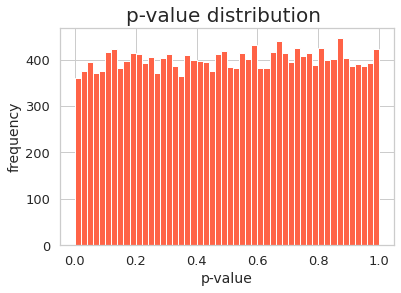

α=0.05, FPR=0.04645


In [170]:
# Симуляция t-test

result = mod.t_simulation(usc.age[usc.group == 1], usc.age[usc.group == 2], 20000)
mod.FPR_graph(result)

##### Gender

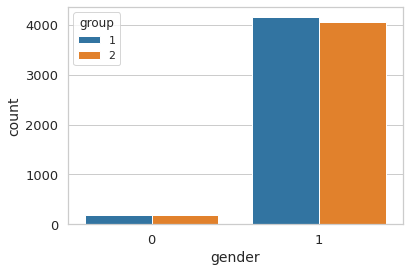

In [171]:
sns.countplot(data=usc, x='gender', hue='group', palette='tab10')

Так как у нас две категориальные переменные, то следует воспользоваться критерием хи-квадрат.

In [172]:
# Таблица сопряженности

pd.crosstab(usc.gender, usc.group)

group,1,2
gender,,
0,182,195
1,4157,4069


In [173]:
stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(usc.gender, usc.group))
print('pvalue =', p)

pvalue = 0.4207205052772518


##### Country

In [174]:
# Создадим таблицу с двумя массива с количеством пользователей для каждой контрольной группы

control_country = usc\
    .groupby(['country', 'group'])\
    .agg({'country': 'count'})\
    .rename(columns={'country': 'N'})\
    .reset_index()\
    .pivot(index='country', columns='group', values='N')\
    .fillna(0)
control_country.head()

group,1,2
country,,
Algeria,2.0,0.0
Argentina,389.0,397.0
Armenia,1.0,0.0
Australia,50.0,51.0
Austria,0.0,2.0


In [175]:
# Воспользуемся критерием x-квадрат, так как страна пользователя переменная категориальная

stat, p, dof, expected = ss.chi2_contingency([control_country[1], control_country[2]])
print('pvalue =', p)

pvalue = 0.26675503409839196


##### joined_at

Сравним распределение регистрации пользователей в двух контрольных группах по дням .

In [176]:
# Объединим логи транзакаций и создадим колонку с месяцем регистрации

trc1['group'] = 1
trc2['group'] = 2
trc = pd.concat([trc1, trc2], ignore_index=True)
trc['joined_at_month'] = trc.joined_at.dt.to_period('M')

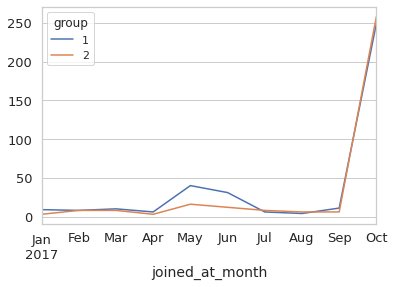

In [177]:
control_joined_month = trc\
    .groupby(['joined_at_month', 'group'])\
    .agg({'uid':'count'})\
    .reset_index()\
    .rename(columns={'uid': 'registered_users'})\
    .pivot(index='joined_at_month', columns='group', values='registered_users')\
    .fillna(0)
control_joined_month.plot()

In [178]:
# Проверка на нормальность

print(ss.shapiro((control_joined_month[1])),
      ss.shapiro((control_joined_month[2])), sep='\n')

ShapiroResult(statistic=0.48620206117630005, pvalue=2.506803184587625e-06)
ShapiroResult(statistic=0.40957826375961304, pvalue=3.218795256998419e-07)


In [179]:
# Проведем U-тест Манна-Уитни

ss.mannwhitneyu(control_joined_month[1], control_joined_month[1], alternative='two-sided')

MannwhitneyuResult(statistic=50.0, pvalue=1.0)

##### visit_days

In [180]:
# Преобразуем колонку с номерами дней в колонку списков

usc['visit_days'] = usc.visit_days.apply(lambda x: [] if type(x) == int else x.split(','))

In [181]:
# Добавим колонку с количеством дней посещений
usc['days_count'] = usc.visit_days.apply(lambda x: len(x))

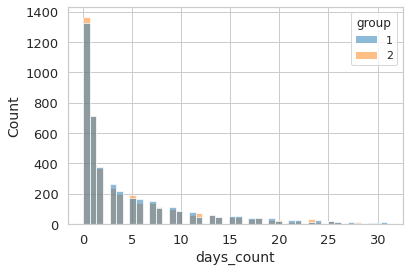

In [182]:
sns.histplot(data=usc, x='days_count', hue='group', palette='tab10')

In [183]:
# Проверка на нормальность

print(ss.shapiro((usc.days_count[usc.group == 1])),
      ss.shapiro((usc.days_count[usc.group == 2])), sep='\n')

ShapiroResult(statistic=0.7478107213973999, pvalue=0.0)
ShapiroResult(statistic=0.7390583753585815, pvalue=0.0)


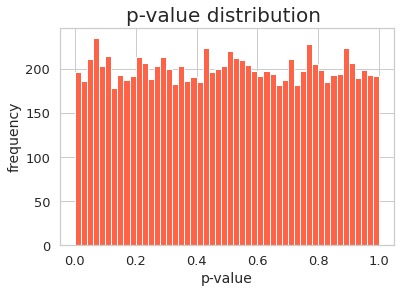

α=0.05, FPR=0.049


In [184]:
result = mod.t_simulation(usc.days_count[usc.group == 1], usc.days_count[usc.group == 2], 10000)
mod.FPR_graph(result)

##### product type

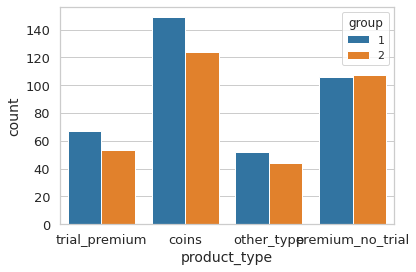

In [185]:
sns.countplot(data=trc, x='product_type', hue='group', palette='tab10')

In [186]:
# Таблица сопряженности для категориальных переменных

pd.crosstab(trc.product_type, trc.group)

group,1,2
product_type,,
coins,149,124
other_type,52,44
premium_no_trial,106,107
trial_premium,67,53


In [187]:
# Воспользуемся критерием xи-квадрат

stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(trc.product_type, trc.group))
print('pvalue =', p)

pvalue = 0.6624229310460596


##### revenue/ARPU

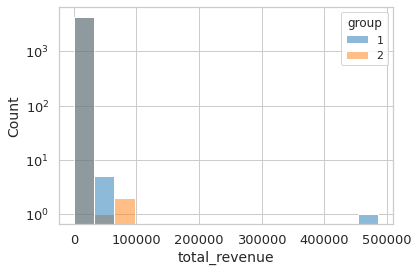

In [188]:
sns.histplot(data=usc, x='total_revenue', hue='group', palette='tab10', log_scale=(False, True))

In [189]:
# Проверка на нормальность данных

print(ss.shapiro((usc.total_revenue[usc.group == 1])),
      ss.shapiro((usc.total_revenue[usc.group == 2])), sep='\n')

ShapiroResult(statistic=0.03985559940338135, pvalue=0.0)
ShapiroResult(statistic=0.1445736289024353, pvalue=0.0)


ARPU в данном случае это среднее значение revenue. Используя бустрап, проведем t-test. 

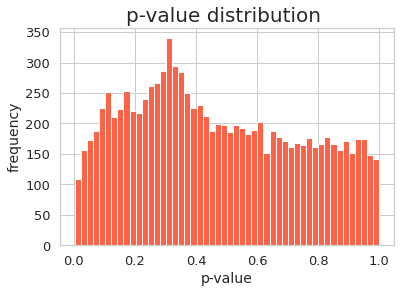

α=0.05, FPR=0.0324


In [190]:
# Симуляция t-testa

result = mod.t_simulation(usc.total_revenue[usc.group == 1], usc.total_revenue[usc.group == 1], 10000, 100)
mod.FPR_graph(result)

In [191]:
print('ARPU первой контрольной группы:', usc.total_revenue[usc.group == 1].mean().round(1),
'ARPU второй контрольной группы:', usc.total_revenue[usc.group == 2].mean().round(1), sep='\n')

ARPU первой контрольной группы:
601.9
ARPU второй контрольной группы:
450.4


##### ARPPU

ARPPU - это среднее значение распределения revenue, учитываяющее только платящих пользователей.
Проведем такое же сравнения, как и для ARPU.

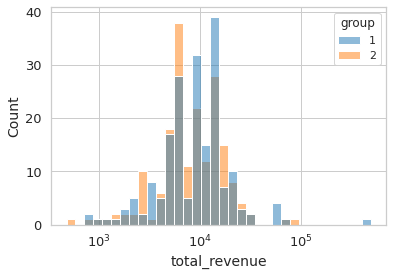

In [192]:
sns.histplot(data=usc.query('total_revenue>0'), x='total_revenue', hue='group', palette='tab10', log_scale=(True, False))

In [193]:
# Проверка на нормальность распределений

print(ss.shapiro(usc.query('total_revenue>0').total_revenue[usc.group == 1]),
      ss.shapiro(usc.query('total_revenue>0').total_revenue[usc.group == 2]), sep='\n')

ShapiroResult(statistic=0.17645704746246338, pvalue=2.8112563471802294e-28)
ShapiroResult(statistic=0.6258848905563354, pvalue=5.0175247612037996e-20)


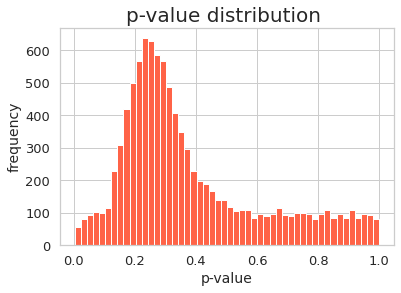

α=0.05, FPR=0.0168


In [194]:
# Симуляция t-testa

result = mod.t_simulation(usc.query('total_revenue>0').total_revenue[usc.group == 1],
                          usc.query('total_revenue>0').total_revenue[usc.group == 2], 10000, 100)
mod.FPR_graph(result)

Несмотря на то, что FPR < 0.05, распределение асимметрично. 

In [195]:
print('ARPPU первой контрольной группы:', usc.query('total_revenue>0')\
      .total_revenue[usc.group == 1].mean().round(1),
      'ARPPU второй контрольной группы:', usc.query('total_revenue>0')\
      .total_revenue[usc.group == 2].mean().round(1), sep='\n')

ARPPU первой контрольной группы:
13601.6
ARPPU второй контрольной группы:
10269.7


##### CR

Сравнивать мы будем конверсии в покупку обычного премиума без учета триал-версии премиума. 

In [196]:
# Создадим список пользователей покупавших обычный премиум, хотя бы один раз

premium_no_trial_list = trc.query('product_type == "premium_no_trial"').uid.unique()

In [197]:
# Добавим в таблицу с информацией пользователя колонку отражающую покупку хотя бы одного премиума

usc['was_premium_no_trial'] = usc.uid.apply(lambda x: 1 if x in premium_no_trial_list else 0)

In [198]:
# Таблица сопряженности

pd.crosstab(usc.was_premium_no_trial, usc.group)

group,1,2
was_premium_no_trial,,
0,4240,4162
1,99,102


In [199]:
# Поскольку конверсия переменная категориальная применим критерий хи-квадрат

stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(usc.was_premium_no_trial, usc.group))
print('pvalue =', p)

pvalue = 0.788834955931526


#### Вывод по результатам A/A теста:

По основным бизнес-метрикам система сплитования отработала хорошо. 
Выборки по возрасту, полу, стране, времени регистрации и типу продукта репрезентативны, но есть статистическая разница между распределенями дней посещения после регистрации. 



<a id="4"></a>

## A/B-тест
[в оглавление](#0)

Прежде чем, мы перейдем к анализу результатов A/B теста, стоит отметить, что в начале задания сказано, что для новых пользователей *из нескольких стран* была изменена стоимость премиум-подписки. Однако, не отмечено, входят ли все представленные в датасетах страны в данную группу или нет. 

In [200]:
trc\
    .query('product_type == "premium_no_trial"')\
    .groupby('country')\
    .agg({'revenue': 'mean'})\
    .merge(trt\
           .query('product_type == "premium_no_trial"')\
           .groupby('country')\
           .agg({'revenue': 'mean'}), how = 'left', on = 'country')\
    .fillna(0)

,revenue_x,revenue_y
country,,
Argentina,6724.250000,9882.600000
Australia,4342.000000,12597.000000
Austria,4056.000000,0.000000
Belgium,5956.166667,12597.000000
Canada,4877.600000,6119.750000
Chile,5825.300000,8181.333333
France,5367.142857,6677.666667
Germany,5816.571429,5167.500000
India,4810.000000,0.000000


Поскольку список стран и величина изменения стоимости обычной премиумной подписки не были даны, а анализ транзакаций не позволяет одноназначно сделать выводы в каких странах была применена новая ценовая политика, а в каких нет, то при сравнительном анализе основных продуктовых метрик, мы будем полагаться на утверждение, что новая ценовая политика премиум-подписки была применена для пользователей всех стран представленных в контрольных и тестовых группах. 

Поскольку результаты А/А теста показали корректную работу системы сплитования, то выборки контрольных групп для последующего анализа будут рассматриваться совместно. 

Датасеты тестовой и контрольных групп объединим, присвоив переменной group значения 0 и 1 соотвественно.

In [201]:
# Подготовим датасеты

ust['group'] = 0
trt['group'] = 0

ust['visit_days'] = ust.visit_days.apply(lambda x: [] if type(x) == int else x.split(','))
ust['days_count'] = ust.visit_days.apply(lambda x: len(x))
trt['joined_at_month'] = trt.joined_at.dt.to_period('M')

In [202]:
# Добавим информацию тестовой группе о наличие обычного премиума

premium_no_trial_list_test = trt.query('product_type == "premium_no_trial"').uid.unique()
ust['was_premium_no_trial'] = ust.uid.apply(lambda x: 1 if x in premium_no_trial_list_test else 0)

In [203]:
# Объединим

users = pd.concat([usc, ust], ignore_index=True)
trans = pd.concat([trc, trt], ignore_index=True)

users.group[users.group != 0] = 1
trans.group[trans.group != 0] = 1

##### ARPU

Предварительно проанализируем распределение total_revenue.

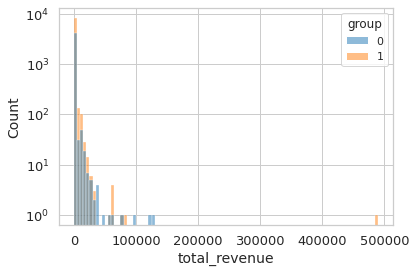

In [204]:
sns.histplot(data=users, x='total_revenue', hue='group', palette='tab10', log_scale=(False, True), binwidth=5000)

In [205]:
# Проверка на нормальность 

print(ss.shapiro((users.total_revenue[users.group == 0])),
      ss.shapiro((users.total_revenue[users.group == 1])), sep='\n')

ShapiroResult(statistic=0.09945714473724365, pvalue=0.0)
ShapiroResult(statistic=0.050388216972351074, pvalue=0.0)


In [209]:
print('ARPU тестовой группы:', users.total_revenue[users.group == 0].mean().round(2),
      'ARPU контрольной группы:', users.total_revenue[users.group == 1].mean().round(2), sep='\n')

ARPU тестовой группы:
544.31
ARPU контрольной группы:
526.79


In [211]:
ss.ttest_ind(users.total_revenue[users.group == 0],
             users.total_revenue[users.group == 1], equal_var=False)

Ttest_indResult(statistic=0.18647757101037393, pvalue=0.8520736627812057)

Результат t-теста не позволяет отклонить нулевую гипотезу об отсутствии статистической значимости между средними.
Поскольку среднее чувствительно к выбросам, исключим из рассмотрения пользователя с аномально большой нормированной выручкой и проведем сравнение заново.

In [213]:
print('ARPU тестовой группы:', users.total_revenue[users.group == 0].mean(),
      'ARPU контрольной группы без выброса:', 
      users.query('total_revenue<40000').total_revenue[users.group == 1].mean(), sep='\n')

ARPU тестовой группы:
544.3131383472609
ARPU контрольной группы без выброса:
416.3130890052356


In [214]:
ss.ttest_ind(users.total_revenue[users.group == 0],
             users.query('total_revenue<40000').total_revenue[users.group == 1], equal_var=False)

Ttest_indResult(statistic=1.7710476030925488, pvalue=0.07660833293035954)

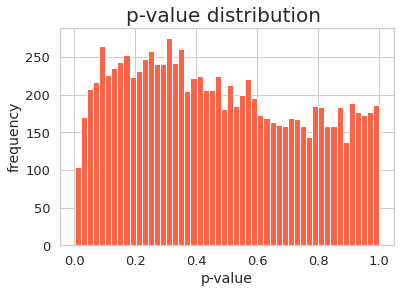

α=0.05, FPR=0.0345


In [216]:
# Симуляция t-testa

result = mod.t_simulation(users.total_revenue[users.group == 0],
                          users.query('total_revenue<40000')\
                          .total_revenue[users.group == 1], 10000, 100)
mod.FPR_graph(result)

Даже с учетом выброса мы не можем отвергнуть нулевую гипотезу t-теста.

##### ARPPU

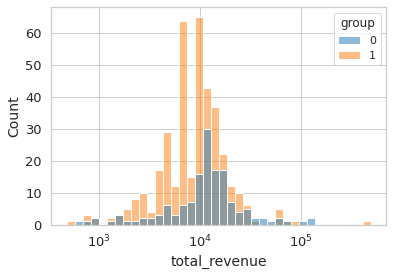

In [146]:
sns.histplot(data=users.query('total_revenue>0'), x='total_revenue', hue='group', palette='tab10', log_scale=(True, False))

In [147]:
# Проверка на нормальность распределений

print(ss.shapiro(users.query('total_revenue>0').total_revenue[users.group == 0]),
      ss.shapiro(users.query('total_revenue>0').total_revenue[users.group == 1]), sep='\n')

ShapiroResult(statistic=0.5640736818313599, pvalue=4.947132531180847e-19)
ShapiroResult(statistic=0.19084203243255615, pvalue=2.3841519432051633e-37)


In [148]:
# Проверка на нормальность после логарифмирования

print(ss.shapiro(np.log(users.query('total_revenue>0').total_revenue[users.group == 0])),
      ss.shapiro(np.log(users.query('total_revenue>0').total_revenue[users.group == 1])), sep='\n')

ShapiroResult(statistic=0.9279718399047852, pvalue=9.65893946158758e-07)
ShapiroResult(statistic=0.9542014002799988, pvalue=1.8091266262842964e-09)


In [221]:
print('ARPPU тестовой группы:', users.query('total_revenue>0').total_revenue[users.group == 0].mean().round(2),
      'ARPPU контрольной группы:', 
      users.query('total_revenue>0').total_revenue[users.group == 1].mean().round(2), sep='\n')

ARPPU тестовой группы:
16060.97
ARPPU контрольной группы:
11957.63


In [219]:
ss.ttest_ind(users.query('total_revenue>0').total_revenue[users.group == 0],
             users.query('total_revenue>0')\
             .total_revenue[users.group == 1], equal_var=False)

Ttest_indResult(statistic=2.016254832184396, pvalue=0.04448869597453669)

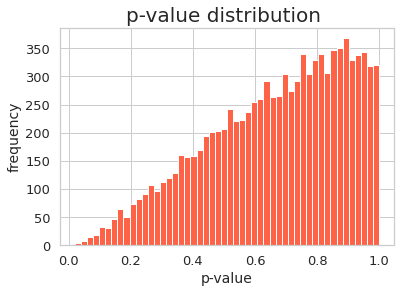

α=0.05, FPR=0.0008


In [222]:
# Симуляция t-testa

result = mod.t_simulation(users.query('total_revenue>0').total_revenue[users.group == 0],
                          users.query('total_revenue>0').total_revenue[users.group == 0],
                          10000, 100)
mod.FPR_graph(result)

Даже с учетом аномального выброса, мы можем говорить о статистической значимой разнице между полученными значениями ARPPU.

#### CR

In [154]:
# Таблица сопряженности

pd.crosstab(users.was_premium_no_trial, users.group)

group,0,1
was_premium_no_trial,,
0,4241,8402
1,67,201


In [155]:
# Используем критерий хи-квадрат

stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(users.was_premium_no_trial, users.group))
print('pvalue =', p)

pvalue = 0.004104012034521867


<a id="5"></a>

## Заключение
[в оглавление](#0)

Проведенный анализ A/A-теста позволяет, утверждать, что система сплитования работает удовлетворительно.
Но наличие аномального выброса вносит свое влияние при сравнительном анализе A/B-теста.

Результаты анализа A/B-теста позволяют утверждать, что введение новой ценовой политики привело к статистически значимому изменению конверсии в покупку обычной премиум-подписки упало с 2.39% до 1.58%. Из чего можно сделать вывод о росте цены за премиум-подписку. Повышение цены как следствие приводит к статистическими значимому росту ARPPU на 15%.
Однако, если ставить во главу угла ARPU, как главную метрику отражающую зависимость выручки от количества пользователей, то статистически значимой разнице в ARPU между двумя группами найдено не было.

Несмотря, на то что, что показано статистически значимое различие между метриками CR и ARPPU в контрольной и тестовой группе, проведенный A/B тест стоит считать неудачным, поскольку его результаты не позволяет ответить на главный вопрос о целесообразности использования новой ценовой политики. 